# Imports

In [1]:
import os
import sys
import glob
import json
import nltk, re, string, collections
from nltk.util import ngrams
from collections import Counter
import pandas as pd
from nltk.tokenize import word_tokenize 

import grpc

import zemberek_grpc.language_id_pb2 as z_langid
import zemberek_grpc.language_id_pb2_grpc as z_langid_g
import zemberek_grpc.normalization_pb2 as z_normalization
import zemberek_grpc.normalization_pb2_grpc as z_normalization_g
import zemberek_grpc.preprocess_pb2 as z_preprocess
import zemberek_grpc.preprocess_pb2_grpc as z_preprocess_g
import zemberek_grpc.morphology_pb2 as z_morphology
import zemberek_grpc.morphology_pb2_grpc as z_morphology_g

import matplotlib.pyplot as plt
import numpy as np

# readJson function

In [2]:
# reading json file and create object to get values
def readJson(fileName):
    f = open(file, "r", encoding='utf-8')
    jsonData = json.load(f)
    words = ""
    
    # find largest text content and return it
    for _, value in jsonData.items():
        if(len(value) > len(words)):
            words = value
            
    return words

# Find ngrams with stopwords

In [3]:
# get all json files in a directory
path = "datasets/*.json"
files = glob.glob(path)

words = ""

# merge all text content in jsons
for file in files:
    jsonWords = readJson(file)
    words = words + jsonWords
    
# tokenize merged texts
tokenized_words = [word.lower() for word in words.split() if len(word) > 1 and re.match("^[A-Z0-9a-zğüşöçİĞÜŞÖÇ]*$", word)]


if not os.path.exists("outputs"):
    os.mkdir("outputs")

# create ngram lists from given array
ngram_list = [
    {"n": 1, "prefix": "unigram"},
    {"n": 2, "prefix": "bigram"},
    {"n": 3, "prefix": "trigram"}
]

for ngram in ngram_list:
    # create ngrams with each has n token
    n = ngrams(tokenized_words, ngram['n']) 
    nFreq = collections.Counter(n)
    
    # create ngram table and export it to csv file
    df = pd.DataFrame(nFreq.most_common(None), columns = ['Words', 'Frequency'])
    df = df.sort_values(by='Frequency', ascending=False)
    p = './outputs/' + ngram['prefix'] + '-with-stopwords.csv'
    df.to_csv(p, index = False, header=True)
    

# Read stopwords file

In [4]:
file = open("stopwords.txt", "r", newline='', encoding='utf-8')
result = file.read()
stopwords = word_tokenize(result)

# Pre Processing

In [5]:
## initialize "zemberek"

channel = grpc.insecure_channel('localhost:6789')

langid_stub = z_langid_g.LanguageIdServiceStub(channel)
normalization_stub = z_normalization_g.NormalizationServiceStub(channel)
preprocess_stub = z_preprocess_g.PreprocessingServiceStub(channel)
morphology_stub = z_morphology_g.MorphologyServiceStub(channel)

# zemberek text analyzer
def analyze(i):
    response = morphology_stub.AnalyzeSentence(z_morphology.SentenceAnalysisRequest(input=i))
    return response;
    
# return last lemma of given word
def pre_processing(word):
    lemmas_string = ""
    analysis_result = analyze(word)
    for a in analysis_result.results:
        best = a.best
        if(best.lemmas[-1] == "UNK"):
            lemmas_string = lemmas_string + " " + a.token
        else:
            lemmas_string = lemmas_string + " " + best.lemmas[-1]
        
        
    return lemmas_string
    

# Find ngrams without stopwords

In [6]:
# get all json files in a directory
path = "datasets/*.json"
files = glob.glob(path)

words = ""

# merge all text content in jsons
for file in files:
    #jsonWords = pre_processing(readJson(file)) # for preprocessing
    jsonWords = readJson(file) # without preprocessing
    words = words + jsonWords

# tokenize merged texts
tokenized_words = [word.lower() for word in words.split() if word.lower() not in stopwords and len(word) > 1 and re.match("^[A-Z0-9a-zğüşöçİĞÜŞÖÇ]*$", word)]

# create ngram lists from given array
ngram_list = [
    {"n": 1, "prefix": "unigram"},
    {"n": 2, "prefix": "bigram"},
    {"n": 3, "prefix": "trigram"}
]

for ngram in ngram_list:
    # create ngrams with each has n token
    n = ngrams(tokenized_words, ngram['n'])
    nFreq = collections.Counter(n)
    
    # create ngram table and export it to csv file
    df = pd.DataFrame(nFreq.most_common(None), columns = ['Words', 'Frequency'])
    df = df.sort_values(by='Frequency', ascending=False)
    p = './outputs/' + ngram['prefix'] + '-without-stopwords.csv'
    df.to_csv(p, index = False, header=True)
    

# Print filtered tokens to file

In [7]:
# print filtered tokens to file
file = open('./filtered-tokens.txt','w', encoding='utf-8')
for word in tokenized_words:
    file.write(" "+word.lower())

file.close()

# Find collocations

In [8]:
bigrams = nltk.collocations.BigramAssocMeasures()
trigrams = nltk.collocations.TrigramAssocMeasures()

bigram_finder = nltk.collocations.BigramCollocationFinder.from_words(tokenized_words)
trigram_finder = nltk.collocations.TrigramCollocationFinder.from_words(tokenized_words)

# for trigram, eliminate trigrams which has 2 or 3 numeric words
trigram_finder.apply_ngram_filter(lambda w1, w2, w3: len(list(filter(lambda x: x.isnumeric(), [w1,w2,w3]))) > 1)

# if frequency filter needs
bigram_finder.apply_freq_filter(0)
trigram_finder.apply_freq_filter(0)

if not os.path.exists("ngrams"):
    os.mkdir("ngrams")

# create bigram table and export to csv file
bigram_freq = bigram_finder.ngram_fd.items()
bigram_table = pd.DataFrame(list(bigram_freq), columns=['Bigram','Frequency']).sort_values(by='Frequency', ascending=False)
bigram_table.to_csv('./ngrams/bigrams.csv', index = False, header=True)

# create trigram table and export to csv file
trigram_freq = trigram_finder.ngram_fd.items()
trigram_table = pd.DataFrame(list(trigram_freq), columns=['Trigram','Frequency']).sort_values(by='Frequency', ascending=False)
trigram_table.to_csv('./ngrams/trigrams.csv', index = False, header=True)

# Methods

### Create directions if not exists

In [9]:
if not os.path.exists("methods"):
    os.mkdir("methods")
    os.mkdir("methods/bigram/")
    os.mkdir("methods/trigram/")

### Draw chart function

In [10]:
def draw_chart(options):
    print("\n--------",options["title"],"--------")
    data = pd.read_csv(options["file"]) 
    words = []
    words = data.head(10)[data.columns[0]]
    freqs = data.head(10)[data.columns[1]]
    colors = ['#bc80bd', '#fb8072', '#80b1d3', '#8dd3c7', '#fdb462',
              '#b3de69', '#bebada', '#F3D1B0', '#fccde5', '#d9d9d9']

    reversed_words = words[::-1]
    reversed_freqs = freqs[::-1]
    plt.bar(words,freqs, color=colors)
    plt.title('-------- ' + options["title"] + ' --------')
    plt.xticks(rotation=90)
    plt.xlabel('Collocations')
    plt.ylabel('Score')
    plt.show() 

    plt.barh(reversed_words, reversed_freqs, color=colors)
    plt.ylabel("collocations")
    plt.xlabel("frequencies")
    plt.title(options["title"])
    plt.show()

## Raw Frequency


-------- Bigram with Raw Frequency --------


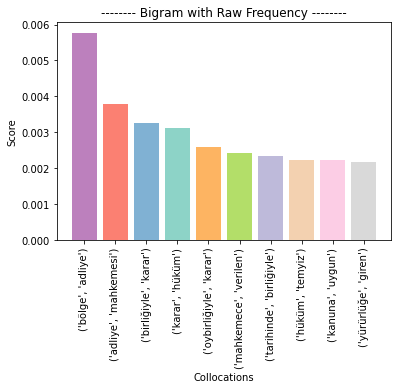

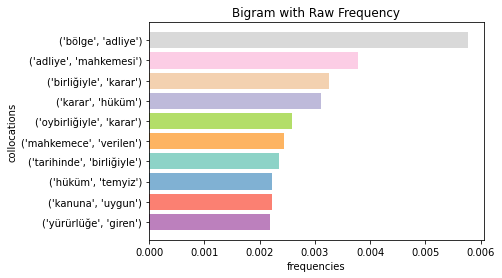


-------- Trigram with Raw Frequency --------


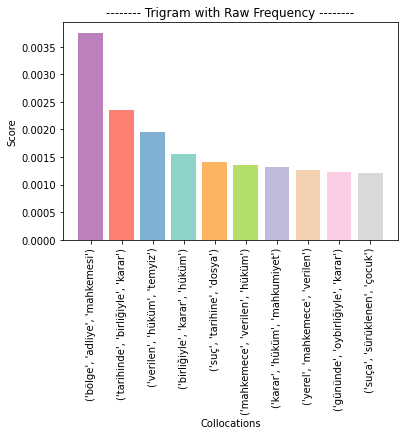

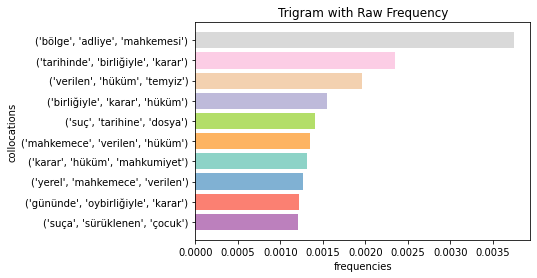

In [11]:
bigramRawFreqTable = pd.DataFrame(list(bigram_finder.score_ngrams(bigrams.raw_freq)), columns=['Bigram','raw_freq']).sort_values(by='raw_freq', ascending=False)
bigramRawFreqTable.to_csv('./methods/bigram/bigramRawFreqTable.csv', index = False, header=True)
draw_chart({"file": './methods/bigram/bigramRawFreqTable.csv', "title": "Bigram with Raw Frequency"})

trigramRawFreqTable = pd.DataFrame(list(trigram_finder.score_ngrams(trigrams.raw_freq)), columns=['Trigram','raw_freq']).sort_values(by='raw_freq', ascending=False)
trigramRawFreqTable.to_csv('./methods/trigram/trigramRawFreqTable.csv', index = False, header=True)
draw_chart({"file": './methods/trigram/trigramRawFreqTable.csv', "title": "Trigram with Raw Frequency"})

## PMI


-------- Bigram with PMI --------


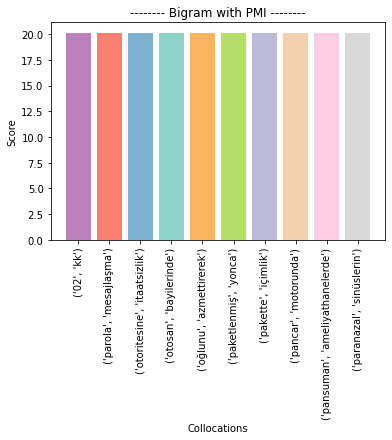

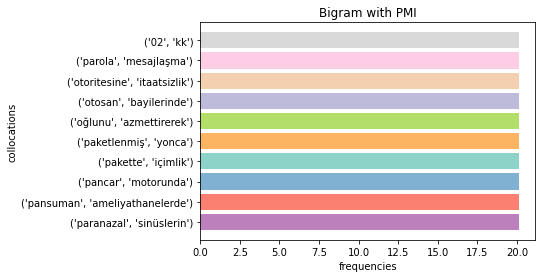


-------- Trigram with PMI --------


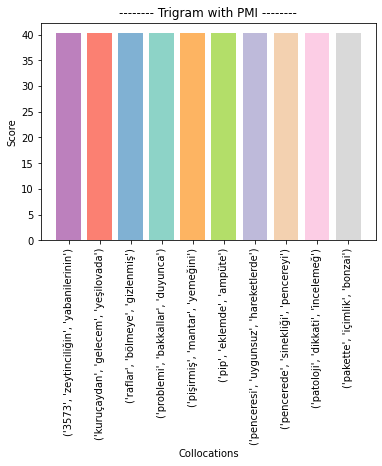

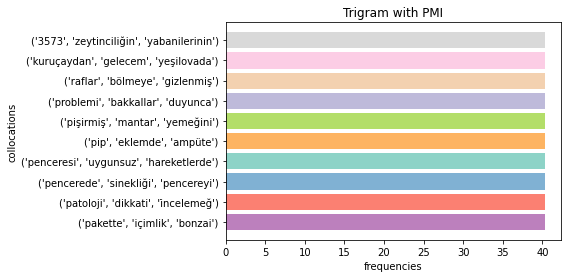

In [12]:
bigramPMITable = pd.DataFrame(list(bigram_finder.score_ngrams(bigrams.pmi)), columns=['Bigram','PMI']).sort_values(by='PMI', ascending=False)
bigramPMITable.to_csv('./methods/bigram/bigramPMITable.csv', index = False, header=True)
draw_chart({"file": './methods/bigram/bigramPMITable.csv', "title": "Bigram with PMI"})

trigramPMITable = pd.DataFrame(list(trigram_finder.score_ngrams(trigrams.pmi)), columns=['Trigram','PMI']).sort_values(by='PMI', ascending=False)
trigramPMITable.to_csv('./methods/trigram/trigramPMITable.csv', index = False, header=True)
draw_chart({"file": './methods/trigram/trigramPMITable.csv', "title": "Trigram with PMI"})

## T-test


-------- Bigram with T-test --------


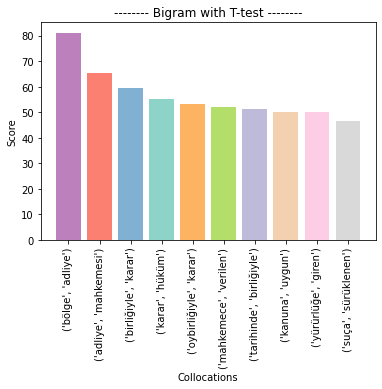

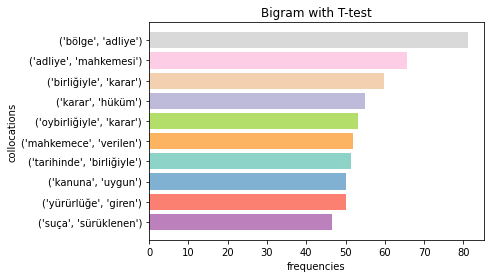


-------- Trigram with T-test --------


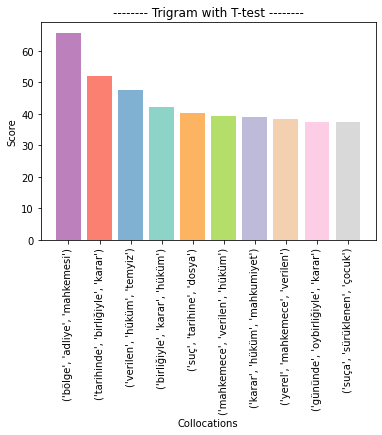

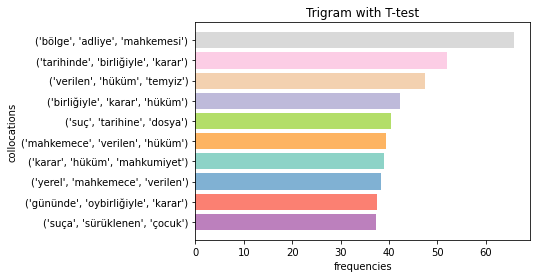

In [13]:
bigramTtable = pd.DataFrame(list(bigram_finder.score_ngrams(bigrams.student_t)), columns=['Bigram','t']).sort_values(by='t', ascending=False)
bigramTtable.to_csv('./methods/bigram/bigramTtable.csv', index = False, header=True)
draw_chart({"file": './methods/bigram/bigramTtable.csv', "title": "Bigram with T-test"})

trigramTtable = pd.DataFrame(list(trigram_finder.score_ngrams(trigrams.student_t)), columns=['Trigram','t']).sort_values(by='t', ascending=False)
trigramTtable.to_csv('./methods/trigram/trigramTtable.csv', index = False, header=True)
draw_chart({"file": './methods/trigram/trigramTtable.csv', "title": "Trigram with T-test"})

## Chi-Square


-------- Bigram with Chi-Square --------


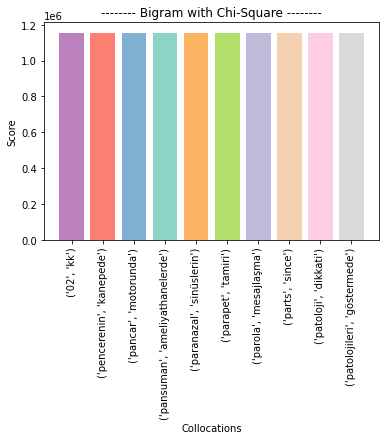

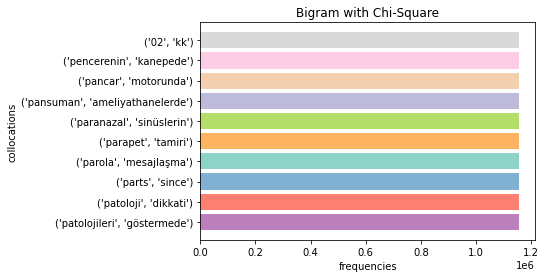


-------- Trigram with Chi-Square --------


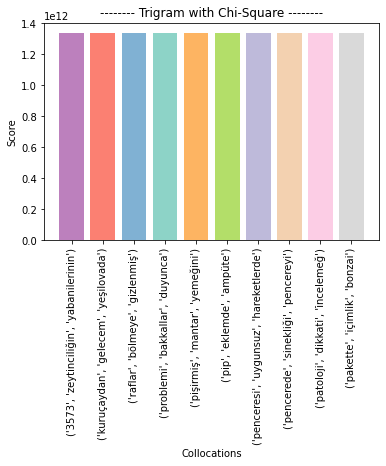

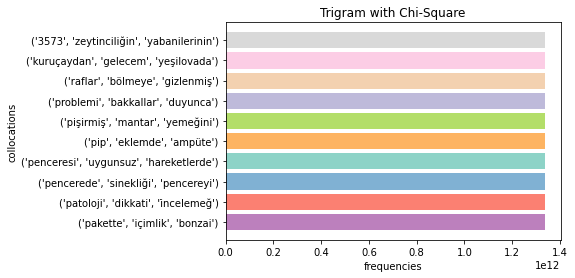

In [14]:
bigramChiTable = pd.DataFrame(list(bigram_finder.score_ngrams(bigrams.chi_sq)), columns=['Bigram','chi-sq']).sort_values(by='chi-sq', ascending=False)
bigramChiTable.to_csv('./methods/bigram/bigramChiTable.csv', index = False, header=True)
draw_chart({"file": './methods/bigram/bigramChiTable.csv', "title": "Bigram with Chi-Square"})

trigramChiTable = pd.DataFrame(list(trigram_finder.score_ngrams(trigrams.chi_sq)), columns=['Trigram','chi-sq']).sort_values(by='chi-sq', ascending=False)
trigramChiTable.to_csv('./methods/trigram/trigramChiTable.csv', index = False, header=True)
draw_chart({"file": './methods/trigram/trigramChiTable.csv', "title": "Trigram with Chi-Square"})

## Poisson Stirling


-------- Bigram with Poisson Stirling --------


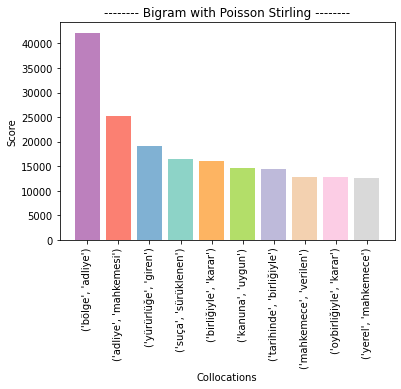

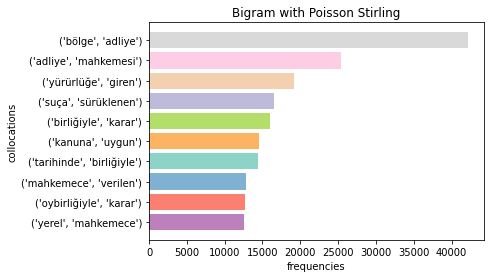


-------- Trigram with Poisson Stirling --------


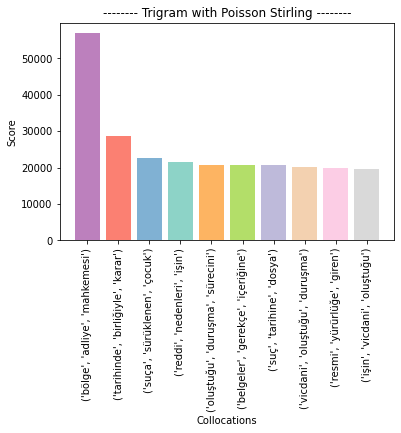

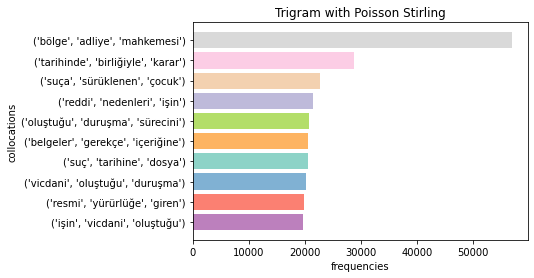

In [15]:
bigramPoissonTable = pd.DataFrame(list(bigram_finder.score_ngrams(bigrams.poisson_stirling)), columns=['Bigram','poisson_stirling']).sort_values(by='poisson_stirling', ascending=False)
bigramPoissonTable.to_csv('./methods/bigram/bigramPoissonTable.csv', index = False, header=True)
draw_chart({"file": './methods/bigram/bigramPoissonTable.csv', "title": "Bigram with Poisson Stirling"})

trigramPoissonTable = pd.DataFrame(list(trigram_finder.score_ngrams(trigrams.poisson_stirling)), columns=['Trigram','poisson_stirling']).sort_values(by='poisson_stirling', ascending=False)
trigramPoissonTable.to_csv('./methods/trigram/trigramPoissonTable.csv', index = False, header=True)
draw_chart({"file": './methods/trigram/trigramPoissonTable.csv', "title": "Trigram with Poisson Stirling"})

## Likelihood Ratio


-------- Bigram with Likelihood --------


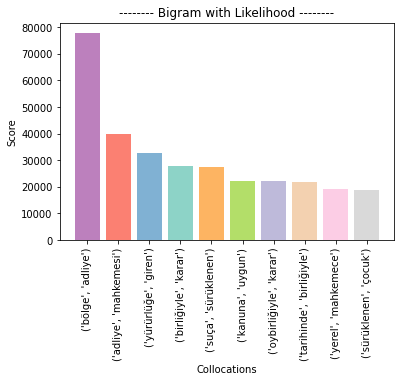

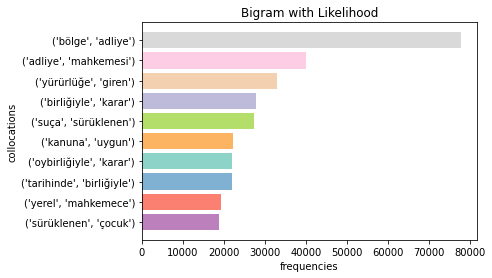


-------- Trigram with Likelihood --------


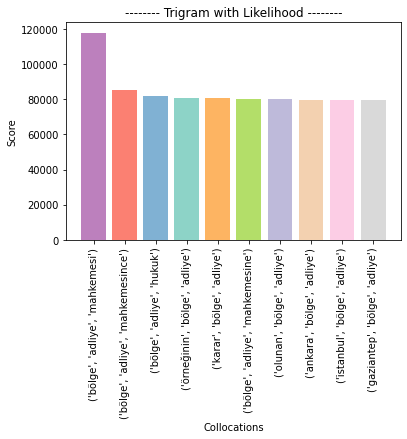

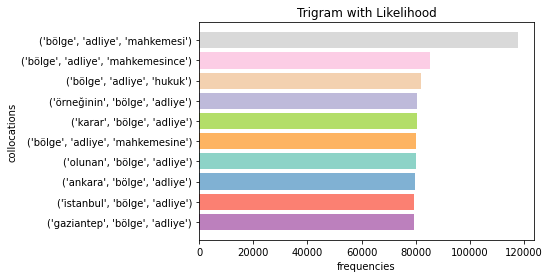

In [16]:
bigramLikelihoodTable = pd.DataFrame(list(bigram_finder.score_ngrams(bigrams.likelihood_ratio)), columns=['Bigram','likelihood_ratio']).sort_values(by='likelihood_ratio', ascending=False)
bigramLikelihoodTable.to_csv('./methods/bigram/bigramLikelihoodTable.csv', index = False, header=True)
draw_chart({"file": './methods/bigram/bigramLikelihoodTable.csv', "title": "Bigram with Likelihood"})

trigramLikelihoodTable = pd.DataFrame(list(trigram_finder.score_ngrams(trigrams.likelihood_ratio)), columns=['Trigram','likelihood_ratio']).sort_values(by='likelihood_ratio', ascending=False)
trigramLikelihoodTable.to_csv('./methods/trigram/trigramLikelihoodTable.csv', index = False, header=True)
draw_chart({"file": './methods/trigram/trigramLikelihoodTable.csv', "title": "Trigram with Likelihood"})

## Jaccard


-------- Bigram with Jaccard --------


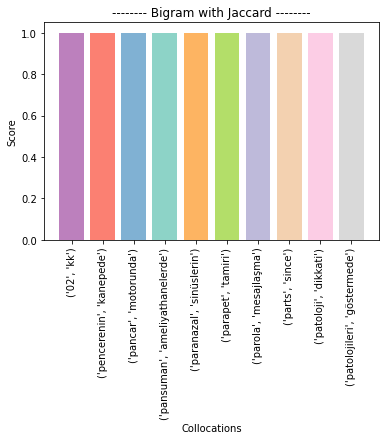

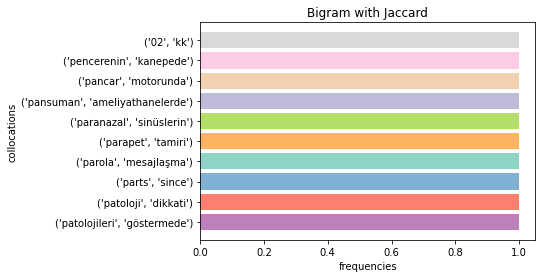


-------- Trigram with Jaccard --------


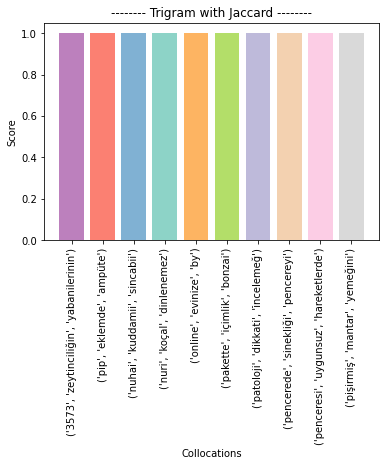

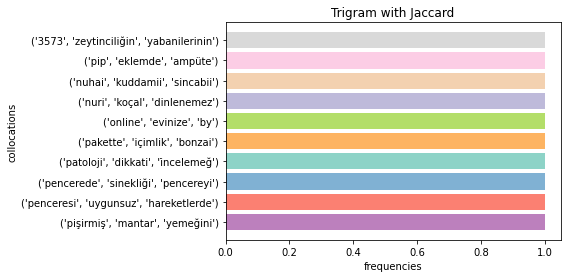

In [17]:
bigramJaccardTable = pd.DataFrame(list(bigram_finder.score_ngrams(bigrams.jaccard)), columns=['Bigram','jaccard']).sort_values(by='jaccard', ascending=False)
bigramJaccardTable.to_csv('./methods/bigram/bigramJaccardTable.csv', index = False, header=True)
draw_chart({"file": './methods/bigram/bigramJaccardTable.csv', "title": "Bigram with Jaccard"})

trigramJaccardTable = pd.DataFrame(list(trigram_finder.score_ngrams(trigrams.jaccard)), columns=['Trigram','jaccard']).sort_values(by='jaccard', ascending=False)
trigramJaccardTable.to_csv('./methods/trigram/trigramJaccardTable.csv', index = False, header=True)
draw_chart({"file": './methods/trigram/trigramJaccardTable.csv', "title": "Trigram with Jaccard"})

# Draw Unigrams, Bigrams, Trigrams


-------- Bigram With Stopwords --------


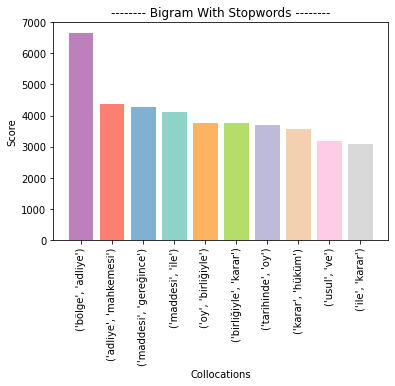

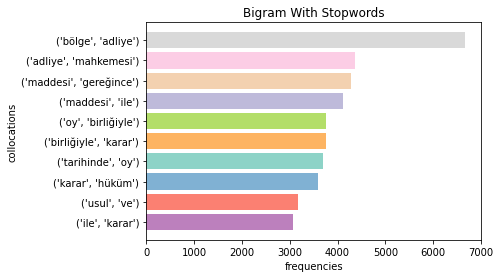


-------- Bigram Without Stopwords --------


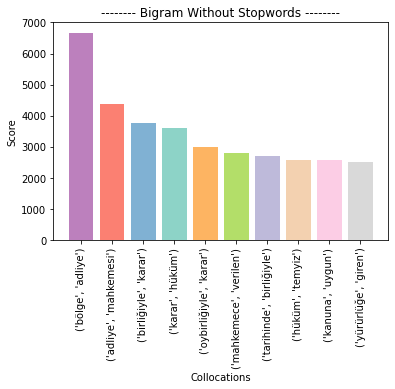

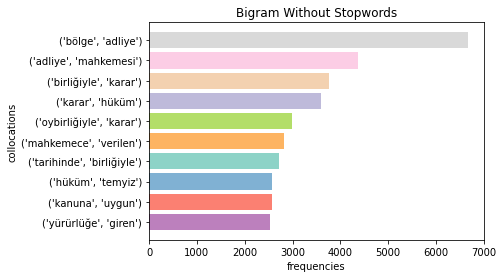


-------- Trigram With Stopwords --------


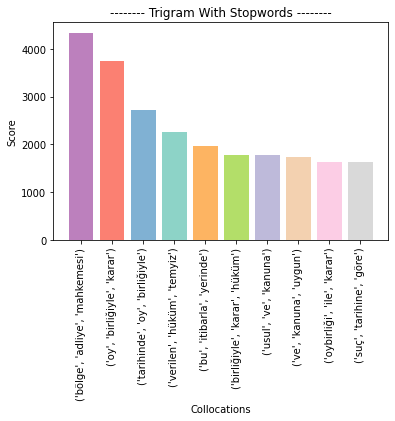

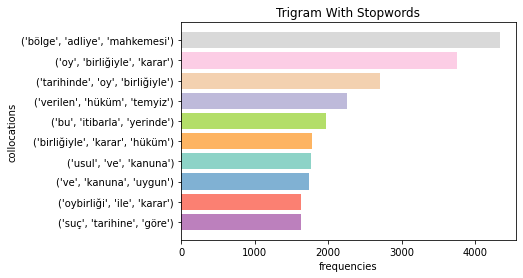


-------- Trigram Without Stopwords --------


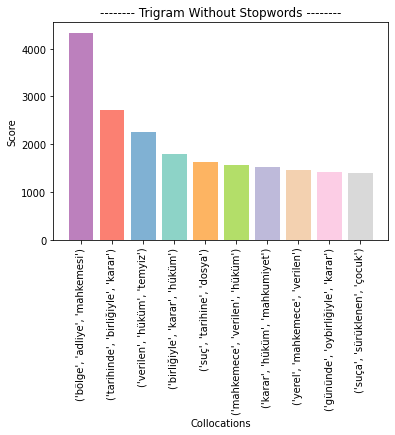

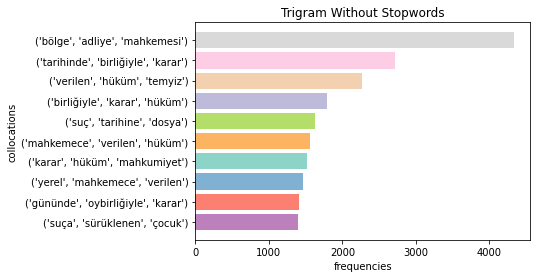


-------- Unigram With Stopwords --------


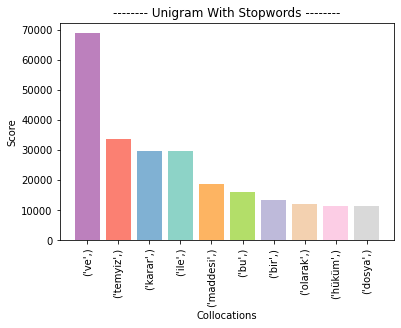

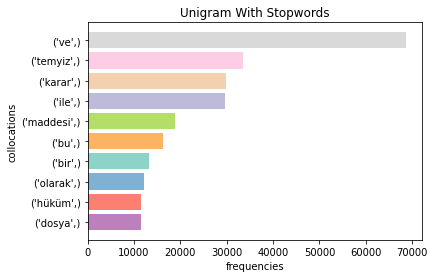


-------- Unigram Without Stopwords --------


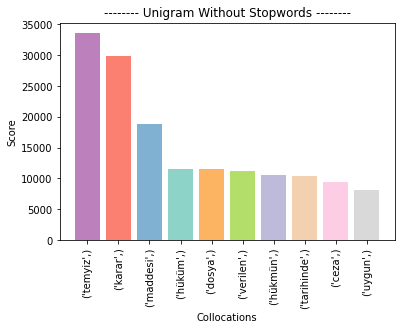

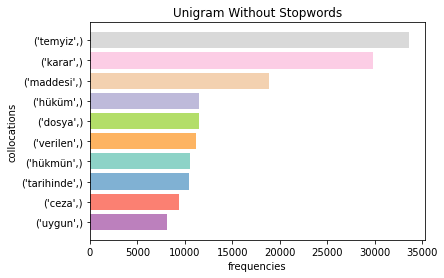

In [18]:
path = "outputs/*.csv"
files = glob.glob(path)

for file in files:
    title = re.search('outputs\\\(.+?).csv', file).group(1).replace("-", " ").title()
    draw_chart({"file": file, "title": title})

